<a href="https://colab.research.google.com/github/cs-deep-quickdraw/notebooks/blob/master/notebooks/cnn_28x28bitmaps_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the notebook used to train CNNs on 28x28 grayscale bitmaps.

In [1]:
!wget 'https://raw.githubusercontent.com/cs-deep-quickdraw/notebooks/master/100_classes.txt'
!mkdir data

--2020-03-01 18:25:12--  https://raw.githubusercontent.com/cs-deep-quickdraw/notebooks/master/100_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘100_classes.txt’

100_classes.txt     100%[===================>]     760  --.-KB/s    in 0s      

2020-03-01 18:25:12 (170 MB/s) - ‘100_classes.txt’ saved [760/760]



In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import urllib.request

f = open("100_classes.txt","r")
# And for reading use
classes = [cls.strip() for cls in f.readlines()]
f.close()

def download(classes):
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for i, c in enumerate(classes):
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print((1+i)/len(classes), c, path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [4]:
download(classes)

0.01 drums https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
0.02 sun https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
0.03 laptop https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
0.04 anvil https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
0.05 baseball_bat https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
0.06 ladder https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
0.07 eyeglasses https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
0.08 grapes https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
0.09 book https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
0.1 dumbbell https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
0.11 traffic_light https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tra

In [5]:
!ls data

airplane.npy	  circle.npy	    key.npy	      shorts.npy
alarm_clock.npy   clock.npy	    knife.npy	      shovel.npy
anvil.npy	  cloud.npy	    ladder.npy	      smiley_face.npy
apple.npy	  coffee_cup.npy    laptop.npy	      snake.npy
axe.npy		  cookie.npy	    light_bulb.npy    sock.npy
baseball_bat.npy  cup.npy	    lightning.npy     spider.npy
baseball.npy	  diving_board.npy  line.npy	      spoon.npy
basketball.npy	  donut.npy	    lollipop.npy      square.npy
beard.npy	  door.npy	    microphone.npy    star.npy
bed.npy		  drums.npy	    moon.npy	      stop_sign.npy
bench.npy	  dumbbell.npy	    mountain.npy      suitcase.npy
bicycle.npy	  envelope.npy	    moustache.npy     sun.npy
bird.npy	  eyeglasses.npy    mushroom.npy      sword.npy
book.npy	  eye.npy	    pants.npy	      syringe.npy
bread.npy	  face.npy	    paper_clip.npy    table.npy
bridge.npy	  fan.npy	    pencil.npy	      tennis_racquet.npy
broom.npy	  flower.npy	    pillow.npy	      tent.npy
butterfly.npy	  frying_pan.npy    pizza.np

In [0]:
BASE_MODEL_PATH = "/content/drive/My Drive/models"

Test class: drums


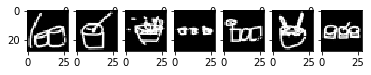

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Display one image
test_cls = np.load(f'data/{classes[0]}.npy')
print(f"Test class: {classes[0]}")

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7)

ax1.imshow(test_cls[0].reshape(28, 28), cmap='gray')
ax2.imshow(test_cls[1].reshape(28, 28), cmap='gray')
ax3.imshow(test_cls[2].reshape(28, 28), cmap='gray')
ax4.imshow(test_cls[3].reshape(28, 28), cmap='gray')
ax5.imshow(test_cls[26001].reshape(28, 28), cmap='gray')
ax6.imshow(test_cls[26002].reshape(28, 28), cmap='gray')
ax7.imshow(test_cls[26003].reshape(28, 28), cmap='gray')

In [0]:
N_TEST = 20_000 # first 20k images are for test purpose

In [0]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

torch.manual_seed(42)
np.random.seed(42)

class DrawDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        assert len(self.X) == len(self.Y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = torch.Tensor(self.X[idx]).type('torch.FloatTensor')
        y = self.Y[idx]

        if self.transform:
            x = self.transform(x)

        return [x, y]

def load_dataset(max_classes=10, max_images_per_class=20000, transform=None):
  X = None
  Y = []

  for i, cls in enumerate(classes[:max_classes]):
    data = np.load(f'data/{cls}.npy')[N_TEST:N_TEST+max_images_per_class].reshape(max_images_per_class, 1, 28, 28)
    if X is not None:
      X = np.concatenate((X, data))
    else:
      X = data

    Y.extend([i for _ in range(max_images_per_class)])

  return DrawDataset(X, Y, transform=transform)

In [0]:
# N_IMAGES_PER_CLASS = 20_000 to get the same results as the ones in the report
N_IMAGES_PER_CLASS = 200

In [0]:
from torchvision import transforms

# If using model pretrained with ImageNet

# means et std from ImageNet dataset
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    lambda x: x / 255,
    lambda x: x.repeat(3,1,1),
    transforms.Normalize(mean=mean, std=std)
])

dataset = load_dataset(max_classes=100, max_images_per_class=N_IMAGES_PER_CLASS, transform=data_transforms)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))])

In [0]:
# # If using model trained from scratch
# dataset = load_dataset(max_classes=100, max_images_per_class=N_IMAGES_PER_CLASS)

In [0]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))])

In [14]:
print(len(train_dataset))
print(train_dataset[0][0].shape)

16000
torch.Size([3, 28, 28])


In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

device = cuda


In [0]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=batch_size,
                 shuffle=True)

val_loader = torch.utils.data.DataLoader(
                 dataset=val_dataset,
                 batch_size=batch_size,
                 shuffle=False)

In [17]:
print('total training batch number: {}'.format(len(train_loader)))
print('total validation batch number: {}'.format(len(val_loader)))

total training batch number: 250
total validation batch number: 63


In [0]:
# define logistic regression model

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(784, 100)

    def forward(self, x):
        x = x.view(-1, 784) # reshape the tensor
        x = self.linear(x)
        return x

In [0]:
# define MLP model
DATA_SIZE = 784
NUM_HIDDEN_1 = 512
NUM_HIDDEN_2 = 256
NUM_CLASSES = 100

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(DATA_SIZE, NUM_HIDDEN_1)
        self.fc2 = nn.Linear(NUM_HIDDEN_1, NUM_HIDDEN_2)
        self.fc3 = nn.Linear(NUM_HIDDEN_2, NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # reshape the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
import torchvision.models as models

In [0]:
resnet = models.resnet18(pretrained=False, num_classes=100)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [0]:
resnet34 = models.resnet34(pretrained=False, num_classes=100)
resnet34.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [0]:
resnet50 = models.resnet50(pretrained=False, num_classes=100)
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [0]:
mobilenet = models.mobilenet_v2(pretrained=False, num_classes=100)
mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

In [25]:
resnet_pretrained = models.resnet18(pretrained=True)
resnet_pretrained.fc = nn.Linear(in_features=resnet_pretrained.fc.in_features, out_features=100, bias=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [26]:
resnet34_pretrained = models.resnet34(pretrained=True)
resnet34_pretrained.fc = nn.Linear(in_features=resnet34_pretrained.fc.in_features, out_features=100, bias=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [27]:
mobilenet_pretrained = models.mobilenet_v2(pretrained=True)
mobilenet_pretrained.classifier[1] = nn.Linear(in_features=mobilenet_pretrained.classifier[1].in_features, out_features=100, bias=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [0]:
resnet_experimental = models.resnet18(pretrained=False, num_classes=100)
resnet_experimental.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)

In [0]:
# define model
# model = LogisticRegression()
# model = MLPNet()
# model = resnet
# model = resnet34
# model = resnet50
# model = mobilenet
# model = resnet_pretrained
# model = resnet34_pretrained
model = mobilenet_pretrained
# model = resnet_experimental

# IF LOADING A MODEL THAT WAS PREVIOUSLY SAVED
# RESUME_EPOCH = 11
# model = torch.load(f'{BASE_MODEL_PATH}/resnet_experimental.model.epoch.{RESUME_EPOCH}')

In [30]:
model.to(device) # puts model on GPU / CPU

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [0]:
# optimization hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)

loss_fn = nn.CrossEntropyLoss()

In [0]:
def evaluate_model(model, loader):
  with torch.no_grad():
    correct = 0
    total = 0
    for batch_idx, (x, target) in enumerate(loader):
      x, target = x.to(device), target.to(device)
      out = model(x)
      _, pred = torch.max(out.data, 1)
      total += target.size(0)
      correct += (pred == target).sum().item()
    return 100. * correct / total

In [0]:
import matplotlib.pyplot as plt

def plot_training(losses, accs, n_epochs):
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('training loss', color=color)
  ax1.plot(losses, color=color)
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.set_ylim([0, 5])

  ax1.set_xlim([0, n_epochs])
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('validation accuracy', color=color)  # we already handled the x-label with ax1
  ax2.plot(accs, color=color)
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim([0, 100])

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()

In [0]:
import time
import copy

def train_model(model, opt, loss_fn, t_loader, v_loader, n_epochs, save=None, resume_epoch=0):

  best_acc, best_model = 0, None
  losses, accs = [], []
  for epoch in range(n_epochs):
    start = time.time()
    epoch_losses = []
    for batch_idx, (x, target) in enumerate(t_loader):
      opt.zero_grad()
      print(f"\rbatch: {batch_idx}, current loss: {np.mean(epoch_losses) if epoch_losses else 'NaN'}", end='')
      x, target = Variable(x).to(device), Variable(target).to(device)
      out = model(x)
      loss = loss_fn(out, target)
      loss.backward()
      opt.step()
      epoch_losses.append(loss.item())

    print("\rEvaluating model on validation dataset...", end='')
    val_acc = evaluate_model(model, v_loader)
    mean_loss = np.mean(epoch_losses)

    losses.append(mean_loss)
    accs.append(val_acc)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model = copy.deepcopy(model.state_dict())

    print(f"\rEpoch: {epoch+1+resume_epoch}/{n_epochs+resume_epoch}, loss: {mean_loss}, validation accuracy: {val_acc}% took: {time.time() - start} seconds")

    if save is not None:
      model_path = f'{BASE_MODEL_PATH}/{save}.model.epoch.{epoch+1+resume_epoch}'
      torch.save(model, model_path)
      print(f"Model saved at: {model_path}")

  print(f"Training ended after {n_epochs} ! Best validation accuracy: {best_acc}%")
  try:
    plot_training(losses, accs, n_epochs)
  except:
    print("error occurred when plotting losses and accuracy training data")
  return best_model, losses, accs

Epoch: 1/5, loss: 3.764226943016052, validation accuracy: 30.275% took: 8.583956241607666 seconds
Epoch: 2/5, loss: 2.5455135707855225, validation accuracy: 44.475% took: 8.18995189666748 seconds
Epoch: 3/5, loss: 2.018394432067871, validation accuracy: 49.55% took: 8.247211933135986 seconds
Epoch: 4/5, loss: 1.7302148008346558, validation accuracy: 53.775% took: 8.546164512634277 seconds
Epoch: 5/5, loss: 1.5275456624031067, validation accuracy: 55.325% took: 8.871612310409546 seconds
Training ended after 5 ! Best validation accuracy: 55.325%


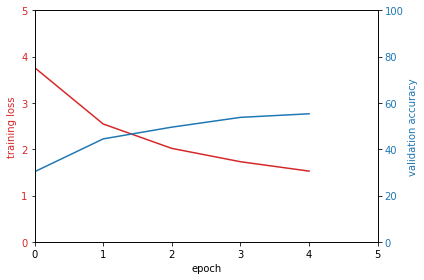

In [35]:
N_EPOCHS = 5
# For saving models
# SAVE = "mobilenet_pretrained"

best_model, losses, accs = train_model(model, optimizer, loss_fn, train_loader, val_loader, N_EPOCHS)
# best_model, losses, accs = train_model(model, optimizer, loss_fn, train_loader, val_loader, N_EPOCHS, save=SAVE)
# best_model, losses, accs = train_model(model, optimizer, loss_fn, train_loader, val_loader, N_EPOCHS, save=SAVE, resume_epoch=RESUME_EPOCH)

In [36]:
import time

model_path = f'cnn_bitmap_quickdraw.model.{time.time()}'
torch.save(best_model, model_path)

print(f"Model saved at: {model_path}")

Model saved at: cnn_bitmap_quickdraw.model.1583087743.316527


In [37]:
print(losses)
print(accs)

[3.764226943016052, 2.5455135707855225, 2.018394432067871, 1.7302148008346558, 1.5275456624031067]
[30.275, 44.475, 49.55, 53.775, 55.325]
